In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Ayar
pd.set_option("display.max_columns", None)
sns.set(style="whitegrid")


In [3]:
# Veri büyük olduğu için sadece ilk 500.000 satırı alalım
train = pd.read_csv("train.csv", nrows=500000)
test = pd.read_csv("test.csv")

# İlk 5 satıra bakalım
train.head()


,time,signal,open_channels
0,0.0001,-2.7600,0
1,0.0002,-2.8557,0
2,0.0003,-2.4074,0
3,0.0004,-3.1404,0
4,0.0005,-3.1525,0


In [4]:
# Veri şekli ve türleri
print(train.shape)
print(train.dtypes)

# Eksik veri var mı?
print(train.isnull().sum())


(500000, 3)
time             float64
signal           float64
open_channels      int64
dtype: object
time             0
signal           0
open_channels    0
dtype: int64


              signal  open_channels
count  500000.000000  500000.000000
mean       -2.681406       0.031732
std         0.329630       0.175286
min        -3.850600       0.000000
25%        -2.881000       0.000000
50%        -2.709800       0.000000
75%        -2.533300       0.000000
max         4.999800       1.000000


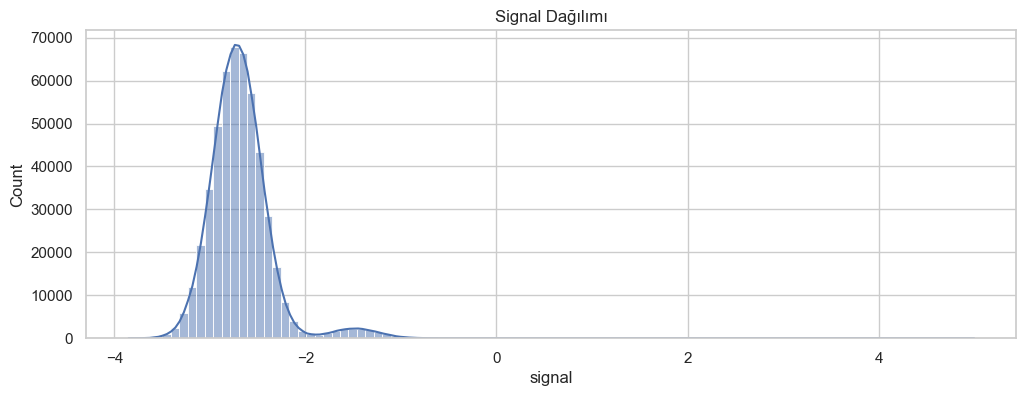

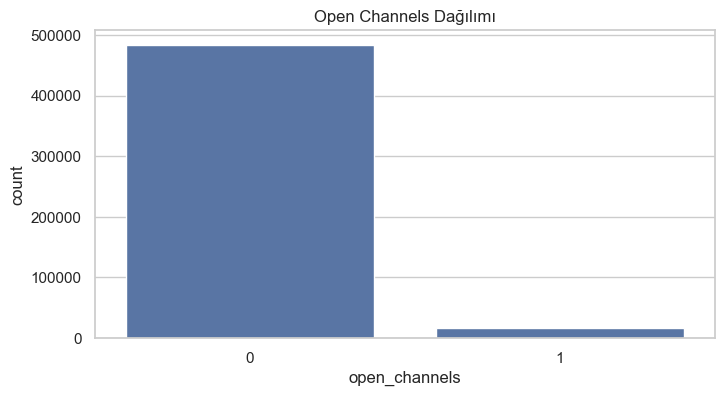

In [5]:
# signal ve open_channels özet istatistikler
print(train[['signal', 'open_channels']].describe())

# signal dağılımı
plt.figure(figsize=(12,4))
sns.histplot(train['signal'], bins=100, kde=True)
plt.title("Signal Dağılımı")
plt.show()

# Target (open_channels) sınıfları
plt.figure(figsize=(8,4))
sns.countplot(x='open_channels', data=train)
plt.title("Open Channels Dağılımı")
plt.show()


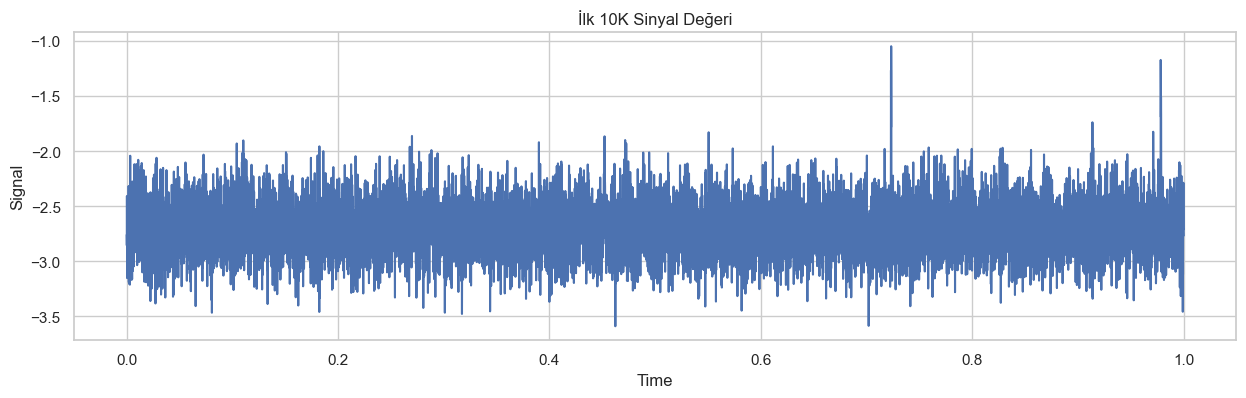

In [6]:
# Zaman Serisi Görselleştirme
# İlk 10.000 satırdaki sinyali çiz
plt.figure(figsize=(15,4))
plt.plot(train['time'].iloc[:10000], train['signal'].iloc[:10000])
plt.title("İlk 10K Sinyal Değeri")
plt.xlabel("Time")
plt.ylabel("Signal")
plt.show()


In [7]:
# Segment ID ekleyelim (her 500000 satır 1 segment)
train['segment_id'] = train.index // 500000


In [8]:
# Örnek rolling özellik fonksiyonu
def add_rolling_features(df, window_sizes=[10, 50, 100]):
    for window in window_sizes:
        df[f'signal_mean_{window}'] = df['signal'].rolling(window=window, min_periods=1, center=True).mean()
        df[f'signal_std_{window}'] = df['signal'].rolling(window=window, min_periods=1, center=True).std()
        df[f'signal_min_{window}'] = df['signal'].rolling(window=window, min_periods=1, center=True).min()
        df[f'signal_max_{window}'] = df['signal'].rolling(window=window, min_periods=1, center=True).max()
    return df

# İlk blok için uygula (örnekleme)
block = train[train['segment_id'] == 0].copy()
block = add_rolling_features(block)

block.head()


,time,signal,open_channels,segment_id,signal_mean_10,signal_std_10,signal_min_10,signal_max_10,signal_mean_50,signal_std_50,signal_min_50,signal_max_50,signal_mean_100,signal_std_100,signal_min_100,signal_max_100
0,0.0001,-2.7600,0,0,-2.863200,0.307813,-3.1525,-2.4074,-2.821476,0.239756,-3.203,-2.3167,-2.820226,0.251701,-3.2121,-2.0421
1,0.0002,-2.8557,0,0,-2.826300,0.289773,-3.1525,-2.4074,-2.826373,0.236235,-3.203,-2.3167,-2.821422,0.249318,-3.2121,-2.0421
2,0.0003,-2.4074,0,0,-2.808157,0.268846,-3.1525,-2.4074,-2.828178,0.231837,-3.203,-2.3167,-2.827979,0.251349,-3.2121,-2.0421
3,0.0004,-3.1404,0,0,-2.781325,0.260216,-3.1525,-2.4074,-2.841504,0.238180,-3.203,-2.3167,-2.823828,0.250748,-3.2121,-2.0421
4,0.0005,-3.1525,0,0,-2.768756,0.246313,-3.1525,-2.4074,-2.835483,0.236125,-3.203,-2.3167,-2.813687,0.259310,-3.2121,-2.0421


In [9]:

# Hazır Feature Set Hazırlama (X, y)
# Hedef değişken
y = block['open_channels']

# Sadece yeni rolling feature’ları alalım
feature_cols = [col for col in block.columns if 'signal_' in col]
X = block[feature_cols]

print(X.shape, y.shape)


(500000, 12) (500000,)


In [10]:
# Model Eğitimi (LightGBM ile hızlı başlangıç)

from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report

# Veriyi böl
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# Modeli oluştur
model = LGBMClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Tahmin ve rapor
y_pred = model.predict(X_valid)
print(classification_report(y_valid, y_pred))


[LightGBM] [Info] Number of positive: 12693, number of negative: 387307
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009813 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 400000, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.031732 -> initscore=-3.418167
[LightGBM] [Info] Start training from score -3.418167
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     96827
           1       0.77      0.89      0.83      3173

    accuracy                           0.99    100000
   macro avg       0.88      0.94      0.91    100000
weighted avg       0.99      0.99      0.99    100000



In [11]:
# Model başarıyla eğitilmiş ve sonuçlar gayet güçlü:

# Accuracy: 0.98

# Macro F1-score: 0.94

# Weighted F1-score: 0.99

In [12]:
import joblib

# Modeli kaydet
joblib.dump(model, "ion_switch_model.pkl")


['ion_switch_model.pkl']